In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import folium

print("geopandas : " + gpd.__version__)
print("numpy     : " + np.__version__)
print("pandas    : " + pd.__version__)
print("folium    : " + folium.__version__)

geopandas : 0.9.0
numpy     : 1.21.5
pandas    : 1.3.5
folium    : 0.13.0


### Data Import & Processing

In [2]:
# import gpkg file
depriv_df = gpd.read_file("../data/depriv_processed.gpkg")
depriv_df.head()

name       code   msoacode                  msoaname  \
0        City of London 001  E02000001  E02000001        City of London 001   
1  Barking and Dagenham 001  E02000002  E02000002  Barking and Dagenham 001   
2  Barking and Dagenham 002  E02000003  E02000003  Barking and Dagenham 002   
3  Barking and Dagenham 003  E02000004  E02000004  Barking and Dagenham 003   
4  Barking and Dagenham 004  E02000005  E02000005  Barking and Dagenham 004   

            boroughname  population  perc_depr_households  perc_pensioncredit  \
0        City of London        8072                   5.2                 9.9   
1  Barking and Dagenham        7235                  31.0                27.5   
2  Barking and Dagenham       10732                  18.9                21.2   
3  Barking and Dagenham        6419                  15.8                21.3   
4  Barking and Dagenham        9056                  22.9                25.3   

   pop_density                                           geometry  
0     0.002704  MULTIPOLYGON (((532419.592 181998.305, 532746....  
1     0.003458  MULTIPOLYGON (((548452.001 189024.718, 548235....  
2     0.005056  MULTIPOLYGON (((548954.500 189063.203, 548874....  
3     0.002498  MULTIPOLYGON (((551943.813 186027.672, 551670....  
4     0.008148  MULTIPOLYGON (((549145.624 187383.875, 549128....

In [3]:
# remove nulls (non-London MSOA)
depriv_df = depriv_df[pd.notnull(depriv_df["msoaname"])]

# multiple the population density by 1000 (pop/m -> pop/km)
depriv_df['pop_density'] *= 1000

### Basic EDA (non-spatial)

In [4]:
# overview of descriptive statistics
depriv_df.describe()

population  perc_depr_households  perc_pensioncredit  pop_density
count    983.000000            983.000000          983.000000   983.000000
mean    8686.357070             19.008749           26.875178     8.791547
std     1634.481711              9.897630           13.000344     5.218073
min     5359.000000              1.100000            2.100000     0.284802
25%     7600.000000             10.650000           16.400000     4.882352
50%     8466.000000             18.100000           25.900000     7.512456
75%     9531.000000             25.800000           36.200000    12.060932
max    15867.000000             49.600000           83.600000    27.893621

<AxesSubplot:>

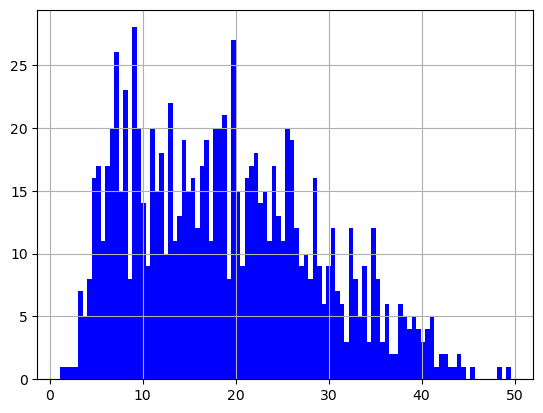

In [5]:
# histgram of the Deprivation Index in London (variable for map1)
depriv_df["perc_depr_households"].hist(bins=100, color='b')

<AxesSubplot:>

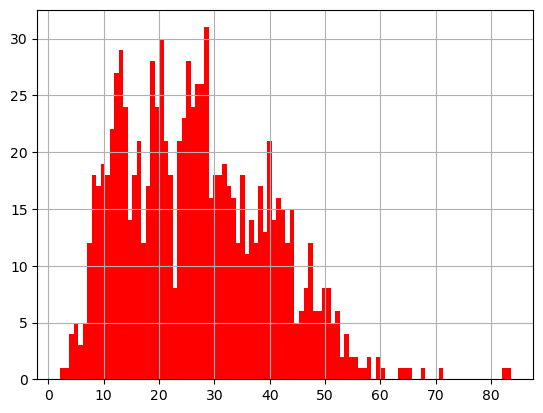

In [6]:
# histgram of the percentage of 60+ adults on pension credits in London (variable for map2)
depriv_df["perc_pensioncredit"].hist(bins=100, color='r')

<AxesSubplot:>

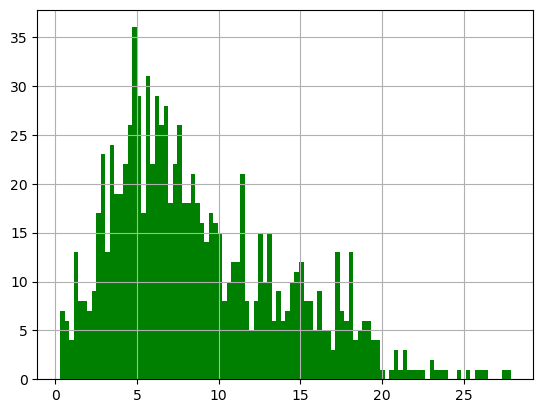

In [7]:
# histgram of the population density in London (variable for map1)
depriv_df["pop_density"].hist(bins=100, color='g')

### Bins Preparation

In [8]:
# calculate bins for map1 (deprivation index) by 8-quantile
bins_map1 = list(depriv_df['perc_depr_households'].quantile(np.linspace(0,1,9)))

# calculate bins for map2 (percentage of 60+ years old population) by 8-quantile
bins_map2 = list(depriv_df['perc_pensioncredit'].quantile(np.linspace(0,1,9)))

# calculate bins for map3 (population density) by fixed range
bins_map3 = [min(depriv_df["pop_density"]), 5., 10.0, 15.0, 20.0, 25.0, max(depriv_df["pop_density"])]
#bins_map3 = list(depriv_df['pop_density'].quantile(np.linspace(0,1,9)))

### Choropleths Creation

In [9]:
# create a map
m = folium.Map(location=[51.509865, -0.118092], tiles='cartodbpositron', zoom_start=10)

# create choropleth (Map1: Deprivation Index in London)
cp1 = folium.Choropleth(
    geo_data = depriv_df,
    name = "Deprivation Index in London",
    data = depriv_df,
    columns=["msoaname", "perc_depr_households"],
    key_on="feature.properties.msoaname",
    fill_color="Blues",
    fill_opacity=1.0,
    line_opacity=0.2,
    legend_name="Deprivation Index",
    bins = bins_map1,
    reset = True
)

folium.GeoJsonTooltip(["msoaname", "perc_depr_households"]).add_to(cp1.geojson)

# create choropleth (Map2: Percentage of 60+ adults on pension credits in London)
cp2 = folium.Choropleth(
    geo_data = depriv_df,
    name = "Percentage of 60+ adults on pension credits in London",
    data = depriv_df,
    columns=["msoaname", "perc_pensioncredit"],
    key_on="feature.properties.msoaname",
    fill_color="Reds",
    fill_opacity=1.0,
    line_opacity=0.2,
    legend_name="Percentage of 60+ adults on pension credits (%)",
    bins = bins_map2,
    reset = True
)

folium.GeoJsonTooltip(["msoaname", "perc_pensioncredit"]).add_to(cp2.geojson)

# create choropleth (Map3: Population density in London)
cp3 = folium.Choropleth(
    geo_data = depriv_df,
    name = "Population density in London",
    data = depriv_df,
    columns=["msoaname", "pop_density"],
    key_on="feature.properties.msoaname",
    fill_color="Greens",
    fill_opacity=1.0,
    line_opacity=0.2,
    legend_name="Population Density (k-people / km\u00b2)",
    bins = bins_map3,
    reset = True
)

# attach popups for each MSOA
folium.GeoJsonTooltip(["msoaname", "pop_density"]).add_to(cp3.geojson)

# add choropleth layers to the map (cp1 on the top)
cp3.add_to(m)
cp2.add_to(m)
cp1.add_to(m)

# add layer control on the map
folium.LayerControl().add_to(m)

m

In [10]:
# export the html file
m.save("../output/index.html")